In [1]:
# imports
#bigqueryhelper
from google.cloud import bigquery
import pandas as pd
import numpy as np
import plotly
from matplotlib import pyplot as plt
import seaborn as sns
sns.set_theme(style="whitegrid")
pd.set_option('display.float_format', lambda x: '%.3f' % x)
import requests
import pandas_datareader as web
import datetime as dt
from datetime import datetime

from prophet import Prophet

In [2]:
# API key verification for Google Cloud
import os
os.environ["GOOGLE_APPLICATION_CREDENTIALS"]="/Users/davidhofhuizen/Projects/EDA_Bitcoin-ledger/rugged-ether-350608-2a8031aeb288.json"
client = bigquery.Client()

In [3]:
def cumulative_transaction_processing(df_old):
    df = df_old.copy()

    #df = df[df['address'].isin(adopters)]

    df['balance'] = df['balance'].astype('int')
    df['date'] = pd.to_datetime(df['date'])
    df['balance'] = df['balance'].apply(balance_transform)

    df = df[['date', 'balance']].sort_values(by='date', ascending = True)
    df['cumulative_balance'] = df['balance'].cumsum()
    
    return df[['date', 'cumulative_balance']].rename(columns={'date': 'ds', 'cumulative_balance': 'y'})

def separate_transaction_processing(df_old):
    df = df_old.copy()

    #df = df[df['address'].isin(adopters)]

    df['balance'] = df['balance'].astype('int')
    df['date'] = pd.to_datetime(df['date'])
    df['balance'] = df['balance'].apply(balance_transform)

    df = df[['date', 'balance']].groupby('date').sum().reset_index()
    
    return df.sort_values(by='date', ascending = True)

def address_transaction_processing(df_old):
    df = df_old.copy()

    #df = df[df['address'].isin(adopters)]

    df['balance'] = df['balance'].astype('int')
    df['date'] = pd.to_datetime(df['date'])
    df['balance'] = df['balance'].apply(balance_transform)

    df = df[['date', 'balance','address']].groupby(['date','address']).sum().reset_index()
    
    return df.sort_values(by='date', ascending = True)

def balance_transform(value):
    return value / 100000000

def plot_df(df, x, y, title="", xlabel='Date', ylabel='Balance', dpi=100):
    plt.figure(figsize=(16,5), dpi=dpi)
    plt.ticklabel_format(useOffset=False, style='plain')
    plt.plot(df[x], df[y], color='tab:red')
    plt.gca().set(title=title, xlabel=xlabel, ylabel=ylabel)
    plt.show()

def get_addresses(years):
    #address_list = pd.DataFrame(columns = ['address'])
    address_list = []

    for year in years:
        

        df = pd.read_csv(f'Top100_{year}_3.csv')
        addresses = list(df['address'])

        address_list.extend(addresses)

    address_list = list(set(address_list))

    return address_list

def get_transactions(adopters):
    wealth_development = f"""
    WITH double_entry_book AS (
   -- debits
   SELECT array_to_string(inputs.addresses, ",") as address, inputs.type, -inputs.value as value, DATE(block_timestamp) as date
   FROM `bigquery-public-data.crypto_bitcoin.inputs` as inputs
   UNION ALL
   -- credits
   SELECT array_to_string(outputs.addresses, ",") as address, outputs.type, outputs.value as value, DATE(block_timestamp) as date
   FROM `bigquery-public-data.crypto_bitcoin.outputs` as outputs
    )
    SELECT address, type, sum(value) as balance, date, EXTRACT(YEAR FROM date) as year
    FROM double_entry_book
    where address IN {adopters}
    GROUP BY date, address, type
    ORDER BY balance DESC
    """

    df = run_query(wealth_development)

    return df

def run_query(query):
    query_job = client.query(query)

    iterator = query_job.result(timeout=120)
    rows = list(iterator)

    # Transform the rows into a nice pandas dataframe
    result = pd.DataFrame(data=[list(x.values()) for x in rows], columns=list(rows[0].keys()))
    
    return result

def maxer(value):
    if value < 0:
        value = 0
        return value
    
    else:
        return value


def price_and_cumulative(df_wealth, df_price):

    df_wealth = df_wealth.sort_values(by = 'ds', ascending = True)

    df_price = df_price.reset_index()
    df_price['Date'] = pd.to_datetime(df_price['Date'])

    #get dates to match on
    min_date = min(df_price.Date)
    max_date = datetime.strptime('2022-05-17','%Y-%m-%d')

    df_price = df_price[(df_price.Date < max_date) & (df_price.Date >= min_date)]
    df_wealth = df_wealth[(df_wealth['ds'] < max_date) & (df_wealth['ds'] >= min_date)]

    df_price = df_price[['Date', 'Close', 'Volume']]
    df_wealth = df_wealth[['ds', 'y']].rename(columns={'ds': 'Date', 'y':'Balance'})

    df_merged = pd.merge(df_price, df_wealth, how = 'outer')

    df_merged['Worth'] = df_merged.Balance * df_merged.Close

    return df_merged


def price_and_transaction(df_wealth):

    start = dt.datetime(2009,1,1)
    end = dt.datetime.now()

    df_price = web.DataReader('BTC-USD', 'yahoo', start, end).reset_index()
    
    min_date = min(df_price.Date)
    max_date = datetime.strptime('2022-05-17','%Y-%m-%d')

    df_price = df_price[(df_price.Date < max_date) & (df_price.Date >= min_date)]
    df_wealth = df_wealth[(df_wealth['date'] < max_date) & (df_wealth['date'] >= min_date)]

    df_wealth = df_wealth.rename(columns={'date': 'Date', 'balance': 'Balance'})

    df_merged = pd.merge(df_price, df_wealth, how = 'outer')

    df_merged['Worth'] = df_merged.Balance * df_merged.Close

    return df_merged




In [4]:
early_adopters = tuple(get_addresses(list(range(2009,2016))))
df = get_transactions(early_adopters)

In [5]:
df

,address,type,balance,date,year
0,1JoktQJhCzuCQkt3GnQ8Xddcq4mUgNyXEa,pubkeyhash,21751763438199,2014-12-02,2014
1,1EFJUipfCHFmmTFkF9vvjFKdBf3VbfvarM,pubkeyhash,18283840110794,2014-05-24,2014
2,1FfmbHfnpaZjKFvyi1okTjJJusN455paPH,pubkeyhash,14433639692843,2013-10-25,2013
3,3HyULbPVM739jPVk4i3PKZ4LibhYP1HsLc,scripthash,13417314811081,2014-11-28,2014
4,12WmWuSQCgpEkPQTZ4ABijQaz6TCV69ZpE,pubkeyhash,10525888000000,2011-11-09,2011
...,...,...,...,...,...
36384,1933phfhK3ZgFQNLGSDXvqCn32k2buXY8a,pubkeyhash,-11111461735989,2014-03-09,2014
36385,1JoktQJhCzuCQkt3GnQ8Xddcq4mUgNyXEa,pubkeyhash,-12506381910662,2015-01-21,2015
36386,13Df4x5nQo7boLWHxQCbJzobN5gUNT65Hh,pubkeyhash,-13417314811081,2014-11-28,2014
36387,1FfmbHfnpaZjKFvyi1okTjJJusN455paPH,pubkeyhash,-14434153604935,2014-06-12,2014


In [6]:
processed_df = separate_transaction_processing(df)
processed_df

,date,balance
0,2009-01-13,50.000
1,2009-01-14,161.000
2,2009-01-15,300.000
3,2009-01-16,200.000
4,2009-01-18,250.000
...,...,...
4230,2022-05-09,0.000
4231,2022-05-10,0.000
4232,2022-05-12,0.000
4233,2022-05-14,0.001


In [7]:
joined_data = price_and_transaction(processed_df)

<AxesSubplot:xlabel='Date', ylabel='Close'>

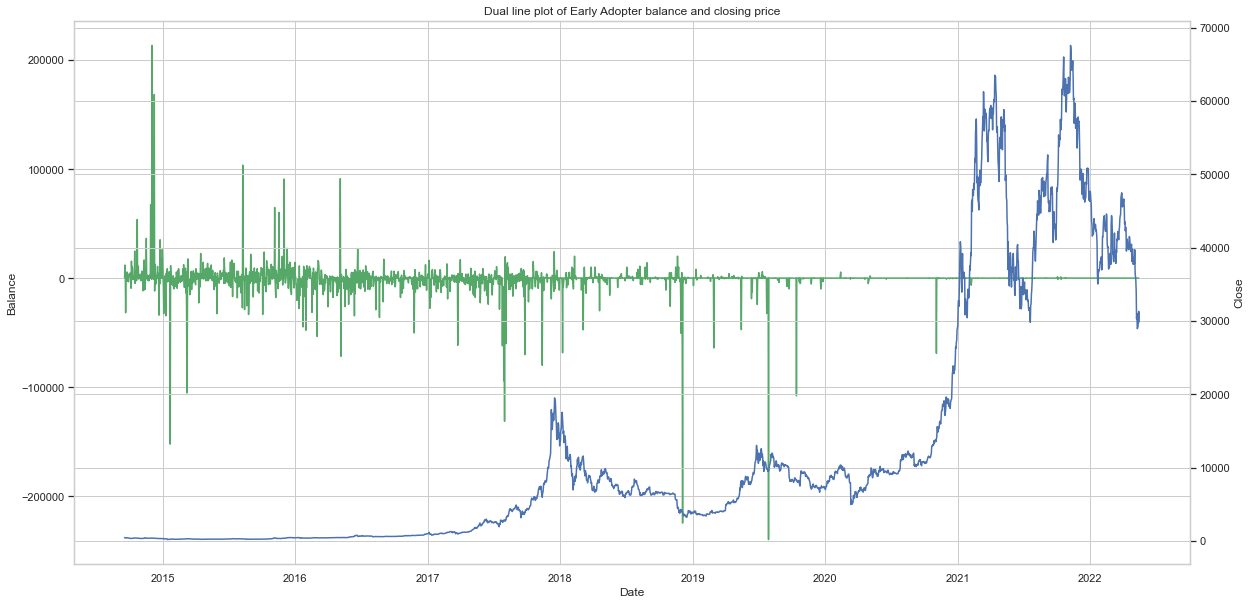

In [8]:
plt.figure(figsize= [20,10])
plt.title("Dual line plot of Early Adopter balance and closing price")
sns.lineplot(data=joined_data[['Date', 'Balance']], x= 'Date', y ='Balance', color="g")
ax2 = plt.twinx()
sns.lineplot(data=joined_data[['Date', 'Close']], x= 'Date', y ='Close', color="b", ax=ax2)

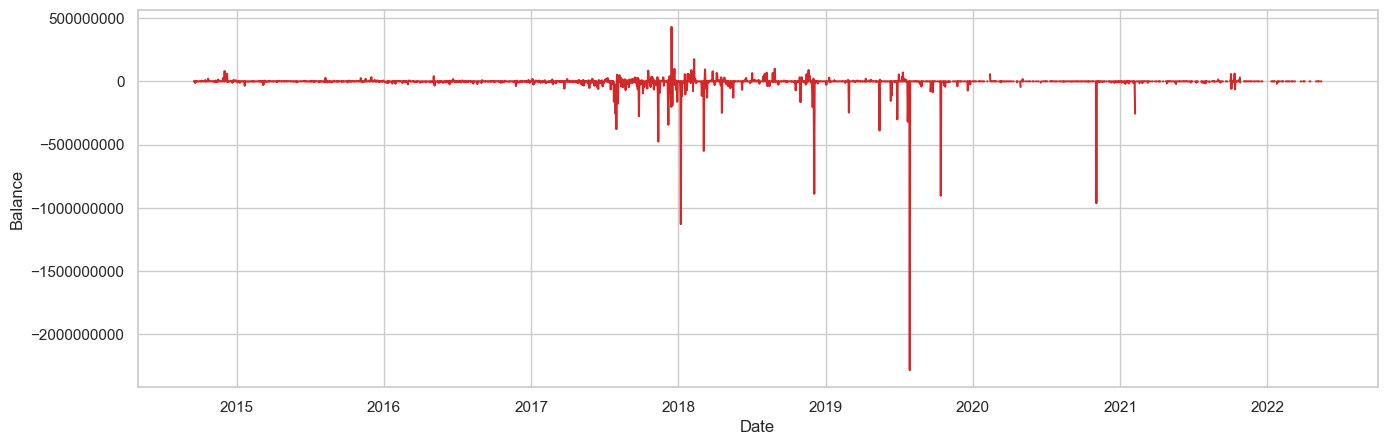

In [9]:
plot_df(joined_data, x = 'Date', y = 'Worth')

In [11]:
processed_df

,date,balance,floor
0,2009-01-13,50.000,0
1,2009-01-14,161.000,0
2,2009-01-15,300.000,0
3,2009-01-16,200.000,0
4,2009-01-18,250.000,0
...,...,...,...
4230,2022-05-09,0.000,0
4231,2022-05-10,0.000,0
4232,2022-05-12,0.000,0
4233,2022-05-14,0.001,0


INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


Initial log joint probability = -8.25281
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      99       10282.7    0.00066103       109.646           1           1      134   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     118       10282.8   0.000166771       183.785   2.401e-06       0.001      194  LS failed, Hessian reset 
     188       10282.9    0.00014175       108.547   2.033e-06       0.001      326  LS failed, Hessian reset 
     199       10282.9   3.49885e-06       63.0346       0.276       0.276      340   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     282       10282.9   7.10296e-07       76.3077      0.3755           1      445   
Optimization terminated normally: 
  Convergence detected: relative gradient magnitude is below tolerance


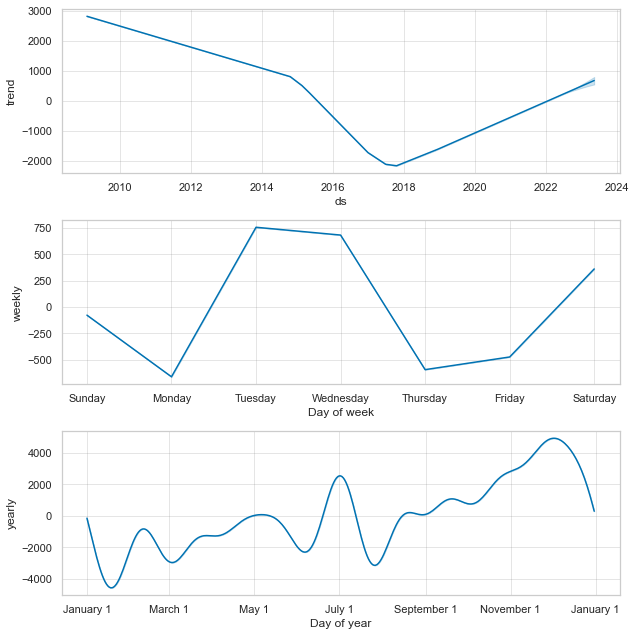

In [18]:

processed_df = processed_df.rename(columns = {'date': 'ds', 'balance': 'y'})
#processed_df['floor'] = 0
m = Prophet()
m.fit(processed_df)
future = m.make_future_dataframe(periods=365)
#future['floor'] = 0
future.tail()

forecast = m.predict(future)
forecast[['ds', 'yhat', 'yhat_lower', 'yhat_upper']].tail()

#fig1 = m.plot(forecast[forecast.yhat > 0])
fig2 = m.plot_components(forecast[forecast.yhat > 0])


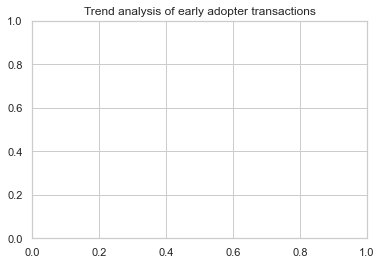

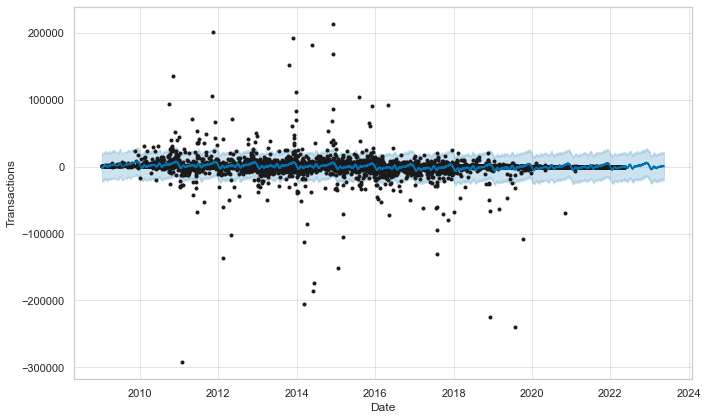

In [21]:
plt.title("Trend analysis of early adopter transactions")
fig1 = m.plot(forecast, xlabel = 'Date', ylabel = 'Transactions')

In [13]:
per_adopter = address_transaction_processing(df)
per_adopter

,date,address,balance
0,2009-01-13,1CRVKdW1nJrZSGUfZU6iSXhK1MQqsnjpz3,50.000
1,2009-01-14,13FMvP1eY9uVqdmPWVUGDppo4qhVNMJH4W,50.000
2,2009-01-14,1BBz9Z15YpELQ4QP5sEKb1SwxkcmPb5TMs,61.000
3,2009-01-14,1FLtWAxjubjMwZUTvjXbJWAzR5DTHeqNY5,50.000
4,2009-01-15,19QKDUJtx9n7Vaga6nX1bVHdsnT4Khfyi6,250.000
...,...,...,...
35646,2022-05-14,1FeexV6bAHb8ybZjqQMjJrcCrHGW9sb6uF,0.000
35645,2022-05-14,1F1tAaz5x1HUXrCNLbtMDqcw6o5GNn4xqX,0.000
35647,2022-05-14,1FfmbHfnpaZjKFvyi1okTjJJusN455paPH,0.000
35648,2022-05-15,12ib7dApVFvg82TXKycWBNpN8kFyiAN1dr,0.000


In [14]:
per_adopter = per_adopter[per_adopter['balance'] < 0]

In [15]:
one_time_users = per_adopter.value_counts('address').reset_index().rename(columns={0: 'Count'})

In [16]:
one_time_users[one_time_users['Count'] == 1]

,address,Count
348,15ZQexYQ27TQJ8MKLWqF9Q4fh2jWTQRrzU,1
349,16b3L5eiyFny9nggwmAjbtx6b4xjwJfu8y,1
350,1PHmAa9Vz65xKbwQ6D1u7TZXjgLCTDCfzm,1
351,1GD8Qh7ebmvdaB8Ampcq8qZqNPr78nzjSP,1
352,1Du2jAQsBQnkkVZkN4oqC46tS78k7WMkVq,1
...,...,...
559,1DCGxk3yoGbensojhxPsWJt3BEGDG5VrU8,1
560,19Mz2o9RDABT74SA9njZqMtJXKEzj2qUoH,1
561,1Lptt8BpsANUNdkysWSornsbmBK88bYrNt,1
562,1LrzZ4SUdgB7vjeWEhcDNK3e2b86w8Fh6w,1
